In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
class LinUCB:
    def __init__(self, T, d, k, alpha, theta):
        self.time_horizon = T
        self.context_dim = d
        self.arm_count = k
        self.alpha = alpha
        self.theta = theta
        self.A = np.zeros((self.arm_count, self.context_dim, self.context_dim)) + np.eye(self.context_dim)
        self.A_inverse = np.zeros_like(self.A)
        self.b = np.zeros((self.arm_count, self.context_dim, 1))
        self.theta_hat = np.zeros((self.arm_count, self.context_dim, 1))
        self.p_curr = np.zeros(self.arm_count)
        self.total_reward = 0
        self.arm_sample_count = np.zeros(self.arm_count)
        self.reward_history = []
        self.regret_history = []
        
    def update(self, arm, context, reward):
        self.A[arm] += np.dot(context, context.T)
        self.b[arm] += reward*context

    def play_once(self):
        contexts = np.random.normal(loc=0.0, scale=1.0, size=(self.arm_count, self.context_dim, 1))
        for a in range(self.arm_count):
            contexts[a] = np.random.uniform(0.0, 1.0)*contexts[a]/np.linalg.norm(contexts[a])    # L2 norm between 0 and 1
            self.A_inverse[a] = np.linalg.inv(self.A[a])
        for a in range(self.arm_count):
            self.theta_hat[a] = np.dot(self.A_inverse[a],self.b[a])
            self.p_curr[a] = float(np.dot(self.theta_hat[a].T, contexts[a]) + self.alpha*np.sqrt(np.dot(np.dot(contexts[a].T, self.A_inverse[a]), contexts[a])))
        curr_arm = np.argmax(self.p_curr)
        curr_reward = np.random.normal(loc=float(np.dot(self.theta[curr_arm].T, contexts[curr_arm])), scale=0.05)
        self.update(curr_arm, contexts[curr_arm], curr_reward)
        self.total_reward += curr_reward
        self.arm_sample_count[curr_arm] += 1
        self.reward_history.append(self.total_reward)
        curr_regret = float(np.max(np.sum(np.sum(self.theta*contexts, axis=2), axis=1)) - curr_reward)
        if(len(self.regret_history)==0):
            self.regret_history.append(curr_regret)
        else:
            self.regret_history.append(self.regret_history[-1] + curr_regret)

    def play(self):
        for t in range(self.time_horizon):
            self.play_once()
    
#     def play(self):
#         for t in range(self.time_horizon):
#             contexts = np.random.normal(loc=0.0, scale=1.0, size=(self.arm_count, self.context_dim, 1))
#             for a in range(self.arm_count):
#                 contexts[a] = np.random.uniform(0.0, 1.0)*contexts[a]/np.linalg.norm(contexts[a])    # L2 norm between 0 and 1
#                 self.A_inverse[a] = np.linalg.inv(self.A[a])
#             for a in range(self.arm_count):
#                 self.theta_hat[a] = np.dot(self.A_inverse[a],self.b[a])
#                 self.p_curr[a] = float(np.dot(self.theta_hat[a].T, contexts[a]) + self.alpha*np.sqrt(np.dot(np.dot(contexts[a].T, self.A_inverse[a]), contexts[a])))
#             curr_arm = np.argmax(self.p_curr)
#             curr_reward = np.random.normal(loc=float(np.dot(self.theta[curr_arm].T, contexts[curr_arm])), scale=0.01)
#             self.update(curr_arm, contexts[curr_arm], curr_reward)
#             self.total_reward += curr_reward
#             self.arm_sample_count[curr_arm] += 1
#             self.reward_history.append(self.total_reward)
#             curr_regret = float(np.max(np.sum(np.sum(self.theta*contexts, axis=2), axis=1)) - curr_reward)
#             if(len(self.regret_history)==0):
#                 self.regret_history.append(curr_regret)
#             else:
#                 self.regret_history.append(self.regret_history[-1] + curr_regret)

In [3]:
d=5
k=10
T=int(1e5)
#alpha= d*np.log(T)
alphas = [0.0, 0.01, 0.1, 0.5, 1.0, 2.0]

theta = np.random.normal(loc=0, scale=1.0, size=(k, d, 1))
for arm in range(k):
    theta[arm] = np.random.uniform(0.0,1.0)*theta[arm]/np.linalg.norm(theta[arm])

num_experiments = 10

avg_regrets = [np.zeros(T) for i in range(6)]
for e in range(num_experiments):
    players = [LinUCB(T, d, k, alphas[i], theta) for i in range(6)]
    for p in range(6):
        players[p].play()
        avg_regrets[p] = (float(e)/float(e+1))*avg_regrets[p] + (1.0/float(e+1))*np.array(players[p].regret_history)

KeyboardInterrupt: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  """
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


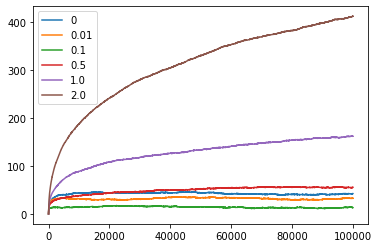

In [4]:
for p in range(6):
    plt.plot(avg_regrets[p])

plt.legend(['0', '0.01', '0.1', '0.5', '1.0', '2.0'])
plt.savefig("single_player_plot_averaged_scale_0p05.jpg", dpi=500, bbox="tight")

In [5]:
print(players[0].arm_sample_count)

[16286.  4648.  9953. 14908. 17119. 15395.  8929.  2274.  4910.  5578.]


In [6]:
for a in range(k):
    print(players[0].arm_sample_count[a], np.linalg.norm(theta[a]))

16286.0 0.8778678904862959
4648.0 0.35269782187064924
9953.0 0.5799772198228578
14908.0 0.804571227466324
17119.0 0.9188137409358526
15395.0 0.8535597154762383
8929.0 0.5470661018906723
2274.0 0.2448085832417991
4910.0 0.3757002532888221
5578.0 0.40564283525473566


In [11]:
class TwoPlayerLinUCB:
    def __init__(self, T, d, k, alpha_A, alpha_B, theta_A, theta_B, gamma):
        self.Alice = LinUCB(T, d, k, alpha_A, theta_A)
        self.Bob = LinUCB(T, d, k, alpha_B, theta_B)
        self.gamma = gamma
        self.time_horizon = T
        
#     def update_Alice(self, arm, arm_type, context, reward):
#         if(arm_type == 'B'):
#             self.Alice.A[arm] = (self.Alice.A[arm]*(self.Bob.arm_sample_count[arm]-1) + (1-self.gamma)*np.dot(context, context.T))/self.Bob.arm_sample_count[arm]
#             self.Alice.b[arm] = (self.Alice.b[arm]*(self.Bob.arm_sample_count[arm]-1) + (1-self.gamma)*reward*context)/self.Bob.arm_sample_count[arm]
#         elif(arm_type == 'A'):
#             self.Alice.A[arm] = (self.Alice.A[arm]*(self.Alice.arm_sample_count[arm]-1) + (self.gamma)*np.dot(context, context.T))/self.Alice.arm_sample_count[arm]
#             self.Alice.b[arm] = (self.Alice.b[arm]*(self.Alice.arm_sample_count[arm]-1) + (self.gamma)*reward*context)/self.Alice.arm_sample_count[arm]
            
#     def update_Bob(self, arm, arm_type, context, reward):
#         if(arm_type == 'A'):
#             self.Bob.A[arm] = (self.Bob.A[arm]*(self.Alice.arm_sample_count[arm]-1) + (1-self.gamma)*np.dot(context, context.T))/self.Alice.arm_sample_count[arm]
#             self.Bob.b[arm] = (self.Bob.b[arm]*(self.Alice.arm_sample_count[arm]-1) + (1-self.gamma)*reward*context)/self.Alice.arm_sample_count[arm]
#         elif(arm_type == 'B'):
#             self.Bob.A[arm] = (self.Bob.A[arm]*(self.Bob.arm_sample_count[arm]-1) + (self.gamma)*np.dot(context, context.T))/self.Bob.arm_sample_count[arm]
#             self.Bob.b[arm] = (self.Bob.b[arm]*(self.Bob.arm_sample_count[arm]-1) + (self.gamma)*reward*context)/self.Bob.arm_sample_count[arm]

#     def update_Alice(self, arm, arm_type, context, reward):
#         if(arm_type == 'B'):
#             self.Alice.A[arm] = (self.Alice.A[arm] + (1-self.gamma)*np.dot(context, context.T))
#             self.Alice.b[arm] = (self.Alice.b[arm] + (1-self.gamma)*reward*context)
#         elif(arm_type == 'A'):
#             self.Alice.A[arm] = (self.Alice.A[arm] + (self.gamma)*np.dot(context, context.T))
#             self.Alice.b[arm] = (self.Alice.b[arm] + (self.gamma)*reward*context)
            
#     def update_Bob(self, arm, arm_type, context, reward):
#         if(arm_type == 'A'):
#             self.Bob.A[arm] = (self.Bob.A[arm] + (1-self.gamma)*np.dot(context, context.T))
#             self.Bob.b[arm] = (self.Bob.b[arm] + (1-self.gamma)*reward*context)
#         elif(arm_type == 'B'):
#             self.Bob.A[arm] = (self.Bob.A[arm] + (self.gamma)*np.dot(context, context.T))
#             self.Bob.b[arm] = (self.Bob.b[arm] + (self.gamma)*reward*context)

    def update_Alice(self, arm, arm_type, context, reward):
        curr_gamma = float(self.Alice.arm_sample_count[arm])/float(self.Alice.arm_sample_count[arm]+self.Bob.arm_sample_count[arm])
        if(arm_type == 'B'):
            self.Alice.A[arm] = (self.Alice.A[arm] + (1-curr_gamma)*np.dot(context, context.T))
            self.Alice.b[arm] = (self.Alice.b[arm] + (1-curr_gamma)*reward*context)
        elif(arm_type == 'A'):
            self.Alice.A[arm] = (self.Alice.A[arm] + (curr_gamma)*np.dot(context, context.T))
            self.Alice.b[arm] = (self.Alice.b[arm] + (curr_gamma)*reward*context)
            
    def update_Bob(self, arm, arm_type, context, reward):
        curr_gamma = float(self.Bob.arm_sample_count[arm])/float(self.Alice.arm_sample_count[arm]+self.Bob.arm_sample_count[arm])
        if(arm_type == 'A'):
            self.Bob.A[arm] = (self.Bob.A[arm] + (1-curr_gamma)*np.dot(context, context.T))
            self.Bob.b[arm] = (self.Bob.b[arm] + (1-curr_gamma)*reward*context)
        elif(arm_type == 'B'):
            self.Bob.A[arm] = (self.Bob.A[arm] + (curr_gamma)*np.dot(context, context.T))
            self.Bob.b[arm] = (self.Bob.b[arm] + (curr_gamma)*reward*context)

    def play_once_Alice(self):
        contexts = np.random.normal(loc=0.0, scale=1.0, size=(self.Alice.arm_count, self.Alice.context_dim, 1))
        for a in range(self.Alice.arm_count):
            contexts[a] = np.random.uniform(0.0, 1.0)*contexts[a]/np.linalg.norm(contexts[a])    # L2 norm between 0 and 1
            self.Alice.A_inverse[a] = np.linalg.inv(self.Alice.A[a])
        for a in range(self.Alice.arm_count):
            self.Alice.theta_hat[a] = np.dot(self.Alice.A_inverse[a],self.Alice.b[a])
            if(np.dot(np.dot(contexts[a].T, self.Alice.A_inverse[a]), contexts[a])<0):
                print(self.Alice.A_inverse[a])
            self.Alice.p_curr[a] = float(np.dot(self.Alice.theta_hat[a].T, contexts[a]) + self.Alice.alpha*np.sqrt(np.dot(np.dot(contexts[a].T, self.Alice.A_inverse[a]), contexts[a])))
        curr_arm = np.argmax(self.Alice.p_curr)
        curr_reward = np.random.normal(loc=float(np.dot(self.Alice.theta[curr_arm].T, contexts[curr_arm])), scale=0.01)
        self.Alice.arm_sample_count[curr_arm] += 1
        self.update_Alice(curr_arm, 'A', contexts[curr_arm], curr_reward)
        self.update_Bob(curr_arm, 'A', contexts[curr_arm], curr_reward)
        self.Alice.total_reward += curr_reward
        self.Alice.reward_history.append(self.Alice.total_reward)
        curr_regret = float(np.max(np.sum(np.sum(self.Alice.theta*contexts, axis=2), axis=1)) - curr_reward)
        if(len(self.Alice.regret_history)==0):
            self.Alice.regret_history.append(curr_regret)
        else:
            self.Alice.regret_history.append(self.Alice.regret_history[-1] + curr_regret)

    def play_once_Bob(self):
        contexts = np.random.normal(loc=0.0, scale=1.0, size=(self.Bob.arm_count, self.Bob.context_dim, 1))
        for a in range(self.Bob.arm_count):
            contexts[a] = np.random.uniform(0.0, 1.0)*contexts[a]/np.linalg.norm(contexts[a])    # L2 norm between 0 and 1
            self.Bob.A_inverse[a] = np.linalg.inv(self.Bob.A[a])
        for a in range(self.Bob.arm_count):
            self.Bob.theta_hat[a] = np.dot(self.Bob.A_inverse[a],self.Bob.b[a])
            if(np.dot(np.dot(contexts[a].T, self.Bob.A_inverse[a]), contexts[a])<0):
                print(self.Bob.A_inverse[a])
            self.Bob.p_curr[a] = float(np.dot(self.Bob.theta_hat[a].T, contexts[a]) + self.Bob.alpha*np.sqrt(np.dot(np.dot(contexts[a].T, self.Bob.A_inverse[a]), contexts[a])))
        curr_arm = np.argmax(self.Bob.p_curr)
        curr_reward = np.random.normal(loc=float(np.dot(self.Bob.theta[curr_arm].T, contexts[curr_arm])), scale=0.01)
        self.Bob.arm_sample_count[curr_arm] += 1
        self.update_Alice(curr_arm, 'B', contexts[curr_arm], curr_reward)
        self.update_Bob(curr_arm, 'B', contexts[curr_arm], curr_reward)
        self.Bob.total_reward += curr_reward
        self.Bob.reward_history.append(self.Bob.total_reward)
        curr_regret = float(np.max(np.sum(np.sum(self.Bob.theta*contexts, axis=2), axis=1)) - curr_reward)
        if(len(self.Bob.regret_history) == 0):
            self.Bob.regret_history.append(curr_regret)
        else:
            self.Bob.regret_history.append(self.Bob.regret_history[-1] + curr_regret)

    def play_concurrent(self):
        player_order = np.zeros(2*self.time_horizon, dtype=np.int32)
        player_order[self.time_horizon:] = 1
        player_order_random = np.random.permutation(player_order)
        for i in range(2*self.time_horizon):
            if(player_order_random[i] == 0):
                self.play_once_Alice()
                #print("Alice -- " + str(self.Alice.total_reward))
            if(player_order_random[i] == 1):
                self.play_once_Bob()
                #print("Bob -- " + str(self.Alice.total_reward))
                
    def play_warmstart(self, warmstart_time):
        player_order = np.zeros(warmstart_time + self.time_horizon, dtype=np.int32)
        player_order[warmstart_time:] = 1
        for i in range(warmstart_time + self.time_horizon):
            if(player_order[i] == 0):
                self.play_once_Alice()
                #print("Alice -- " + str(self.Alice.total_reward))
            if(player_order[i] == 1):
                self.play_once_Bob()
                #print("Bob -- " + str(self.Alice.total_reward))

In [12]:
d=5
k=10
T=int(1e4)
#alpha= d*np.log(T)
alpha = 0.1
gamma = 0.9
theta_A = np.random.normal(loc=0, scale=1.0, size=(k, d, 1))
for arm in range(k):
    theta_A[arm] = np.random.uniform(0.0,1.0)*theta_A[arm]/np.linalg.norm(theta_A[arm])

epsilon = 0.1
theta_B = np.zeros_like(theta_A)
for arm in range(k):
    random_noise = np.random.normal(loc=0, scale=1.0, size=(d, 1))
    theta_B[arm] = theta_A[arm] + np.random.uniform(0.0, epsilon)*random_noise/np.linalg.norm(random_noise)


num_experiments = 50
individual_alice_avg = np.zeros(T)
individual_bob_avg = np.zeros(T)

two_player_concurrent_alice_avg = np.zeros(T)
two_player_concurrent_bob_avg = np.zeros(T)
two_player_warmstart_alice_avg = np.zeros(T)
two_player_warmstart_bob_avg = np.zeros(T)

alice_individual_arm_sample_count_avg = np.zeros(k)
bob_individual_arm_sample_count_avg = np.zeros(k)

alice_two_player_concurrent_arm_sample_count_avg = np.zeros(k)
bob_two_player_concurrent_arm_sample_count_avg = np.zeros(k)
alice_two_player_warmstart_arm_sample_count_avg = np.zeros(k)
bob_two_player_warmstart_arm_sample_count_avg = np.zeros(k)

for e in range(num_experiments):
    Alice = LinUCB(T, d, k, alpha, theta_A)
    Bob = LinUCB(T, d, k, alpha, theta_B)
    Alice.play()
    individual_alice_avg = (float(e)/float(e+1))*individual_alice_avg + (1.0/float(e+1))*np.array(Alice.regret_history)
    alice_individual_arm_sample_count_avg = (float(e)/float(e+1))*alice_individual_arm_sample_count_avg + (1.0/float(e+1))*np.array(Alice.arm_sample_count)
    Bob.play()
    individual_bob_avg = (float(e)/float(e+1))*individual_bob_avg + (1.0/float(e+1))*np.array(Bob.regret_history)
    bob_individual_arm_sample_count_avg = (float(e)/float(e+1))*bob_individual_arm_sample_count_avg + (1.0/float(e+1))*np.array(Bob.arm_sample_count)
    two_players_concurrent = TwoPlayerLinUCB(T, d, k, alpha, alpha, theta_A, theta_B, gamma)
    two_players_warmstart = TwoPlayerLinUCB(T, d, k, alpha, alpha, theta_A, theta_B, gamma)
    two_players_concurrent.play_concurrent()
    two_players_warmstart.play_warmstart(T)
    two_player_concurrent_alice_avg = (float(e)/float(e+1))*two_player_concurrent_alice_avg + (1.0/float(e+1))*np.array(two_players_concurrent.Alice.regret_history)
    alice_two_player_concurrent_arm_sample_count_avg = (float(e)/float(e+1))*alice_two_player_concurrent_arm_sample_count_avg + (1.0/float(e+1))*two_players_concurrent.Alice.arm_sample_count
    two_player_concurrent_bob_avg = (float(e)/float(e+1))*two_player_concurrent_bob_avg + (1.0/float(e+1))*np.array(two_players_concurrent.Bob.regret_history)
    bob_two_player_concurrent_arm_sample_count_avg = (float(e)/float(e+1))*bob_two_player_concurrent_arm_sample_count_avg + (1.0/float(e+1))*two_players_concurrent.Bob.arm_sample_count
    
    two_player_warmstart_alice_avg = (float(e)/float(e+1))*two_player_warmstart_alice_avg + (1.0/float(e+1))*np.array(two_players_warmstart.Alice.regret_history)
    alice_two_player_warmstart_arm_sample_count_avg = (float(e)/float(e+1))*alice_two_player_warmstart_arm_sample_count_avg + (1.0/float(e+1))*two_players_warmstart.Alice.arm_sample_count
    two_player_warmstart_bob_avg = (float(e)/float(e+1))*two_player_warmstart_bob_avg + (1.0/float(e+1))*np.array(two_players_warmstart.Bob.regret_history)
    bob_two_player_warmstart_arm_sample_count_avg = (float(e)/float(e+1))*bob_two_player_warmstart_arm_sample_count_avg + (1.0/float(e+1))*two_players_warmstart.Bob.arm_sample_count
    print("Experiment "+ str(e) + " done")

Experiment 0 done
Experiment 1 done
Experiment 2 done
Experiment 3 done
Experiment 4 done
Experiment 5 done
Experiment 6 done
Experiment 7 done
Experiment 8 done
Experiment 9 done
Experiment 10 done
Experiment 11 done
Experiment 12 done
Experiment 13 done
Experiment 14 done
Experiment 15 done
Experiment 16 done
Experiment 17 done
Experiment 18 done
Experiment 19 done
Experiment 20 done
Experiment 21 done
Experiment 22 done
Experiment 23 done
Experiment 24 done
Experiment 25 done
Experiment 26 done
Experiment 27 done
Experiment 28 done
Experiment 29 done
Experiment 30 done
Experiment 31 done
Experiment 32 done
Experiment 33 done
Experiment 34 done
Experiment 35 done
Experiment 36 done
Experiment 37 done
Experiment 38 done
Experiment 39 done
Experiment 40 done
Experiment 41 done
Experiment 42 done
Experiment 43 done
Experiment 44 done
Experiment 45 done
Experiment 46 done
Experiment 47 done
Experiment 48 done
Experiment 49 done


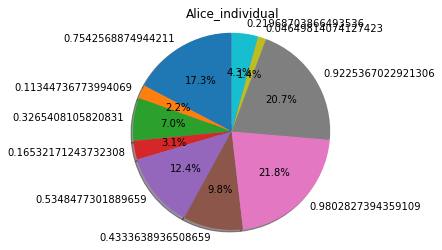

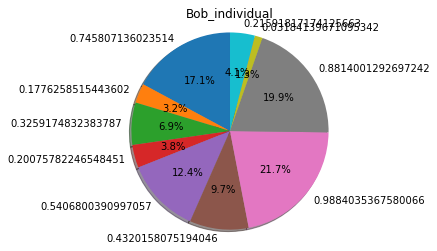

10000
10000


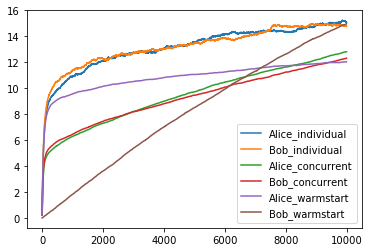

In [20]:
labels = [str(np.linalg.norm(theta_A[a])) for a in range(k)]
sizes = alice_individual_arm_sample_count_avg

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Alice_individual")

plt.show()

labels = [str(np.linalg.norm(theta_B[a])) for a in range(k)]
sizes = bob_individual_arm_sample_count_avg

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Bob_individual")

plt.show()

# labels = [str(np.linalg.norm(theta_A[a])) for a in range(k)]
# sizes = alice_two_player_arm_sample_count_avg

# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title("Alice_two_player")

# plt.show()

# labels = [str(np.linalg.norm(theta_B[a])) for a in range(k)]
# sizes = bob_two_player_arm_sample_count_avg

# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title("Bob_two_player")

# plt.show()

plt.plot(individual_alice_avg)
plt.plot(individual_bob_avg)
plt.plot(two_player_concurrent_alice_avg)
plt.plot(two_player_concurrent_bob_avg)
plt.plot(two_player_warmstart_alice_avg)
plt.plot(two_player_warmstart_bob_avg)
plt.legend(['Alice_individual','Bob_individual','Alice_concurrent','Bob_concurrent', 'Alice_warmstart', 'Bob_warmstart'])
plt.savefig("individual_vs_concurrent_vs_warmstart_variable_gamma_epsilon_0p1_final.jpg", dpi=500)
#plt.show()
print(len(two_players_warmstart.Alice.regret_history))
print(len(Bob.regret_history))

In [15]:
individual_sum = individual_alice_avg + individual_bob_avg
concurrent_sum = two_player_concurrent_alice_avg + two_player_concurrent_bob_avg
warmstart_sum = two_player_warmstart_alice_avg + two_player_warmstart_bob_avg

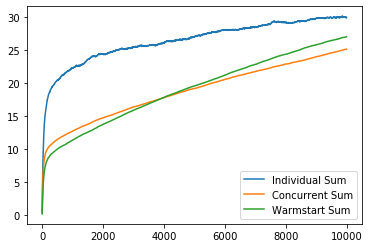

In [21]:
plt.plot(individual_sum)
plt.plot(concurrent_sum)
plt.plot(warmstart_sum)
plt.legend(['Individual Sum','Concurrent Sum','Warmstart Sum'])
plt.savefig("individual_vs_concurrent_vs_warmstart_sum_variable_gamma_epsilon_0p1_final.jpg", dpi=500)